In [1]:
import os
os.chdir(r"C:\Users\91965\Desktop\DataScientistCaseStudy")

In [ ]:
# A new cell added.

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics

In [3]:
def plot_feature_importances_cancer(X,model):
     n_features = X.shape[1]
     plt.barh(range(n_features), model.feature_importances_, align='center')
     plt.yticks(np.arange(n_features), X.columns)
     plt.xlabel("Feature importance")
     plt.ylabel("Feature")

In [4]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")  

In [5]:
#test_df dataset is not containing label i.e., Loan Status is empty.Hence can not be used for testing.
train,test = train_test_split(train_df,test_size = 0.3,random_state = 0,stratify = train_df["Loan Status"])

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47294 entries, 48901 to 51064
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            47294 non-null  int64  
 1   Loan Amount                   46513 non-null  float64
 2   Funded Amount                 47294 non-null  int64  
 3   Funded Amount Investor        47294 non-null  float64
 4   Term                          46678 non-null  float64
 5   Batch Enrolled                47294 non-null  object 
 6   Interest Rate                 47294 non-null  float64
 7   Grade                         47294 non-null  object 
 8   Sub Grade                     47294 non-null  object 
 9   Home Ownership                47294 non-null  object 
 10  Employment Duration           47294 non-null  float64
 11  Verification Status           47294 non-null  object 
 12  Payment Plan                  47294 non-null  object 
 1

**Clearly, we have missing values in the dataset**

#### Percenatge of missing value in each column relative to the total number of data

In [7]:
train.isnull().sum()/len(train)

ID                              0.000000
Loan Amount                     0.016514
Funded Amount                   0.000000
Funded Amount Investor          0.000000
Term                            0.013025
Batch Enrolled                  0.000000
Interest Rate                   0.000000
Grade                           0.000000
Sub Grade                       0.000000
Home Ownership                  0.000000
Employment Duration             0.000000
Verification Status             0.000000
Payment Plan                    0.000000
Loan Title                      0.000000
Debit to Income                 0.000000
Delinquency - two years         0.000000
Inquires - six months           0.000000
Open Account                    0.000000
Public Record                   0.000000
Revolving Balance               0.000000
Revolving Utilities             0.000000
Total Accounts                  0.000000
Initial List Status             0.000000
Total Received Interest         0.000000
Total Received L

## Missing Value Treatment

**Clearly number of missing values is less compared to the data available and the location of missing value in the Loan Amount and Term seems independent ( called missing completely at random (MCAR) )**
1. We can delete the rows of missing values without introducing any bias in the model because missing values are MCAR
2. Use imputation techniques

**Here lets use approch 2 as test data is also have missing values**

In [8]:
mean_inputation = SimpleImputer(strategy = "mean")
mode_imputation = SimpleImputer(strategy = "most_frequent")

train["Loan Amount"] = mean_inputation.fit_transform(train[["Loan Amount"]])

test["Loan Amount"] = mean_inputation.transform(test[["Loan Amount"]])

Lets impute the missing value in *Term* with most common value in that feild

In [9]:
train["Term"] = mode_imputation.fit_transform(train[["Term"]])
test["Term"] = mode_imputation.transform(test[["Term"]])

**Lets see target distribution**

<Axes: >

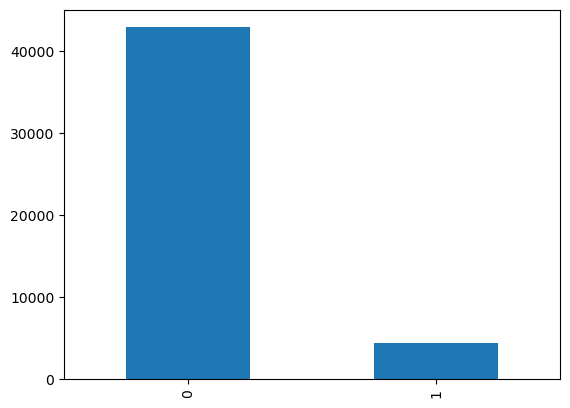

In [10]:
counts = train['Loan Status'].value_counts()      # So target variable is NOT evenly distributed
#print(counts)
counts.plot(kind = 'bar')

In [11]:
train.describe(include = "object")

,Batch Enrolled,Grade,Sub Grade,Home Ownership,Verification Status,Payment Plan,Loan Title,Initial List Status,Application Type
count,47294,47294,47294,47294,47294,47294,47294,47294,47294
unique,41,8,35,3,3,1,109,2,2
top,BAT3873588,C,B4,MORTGAGE,Source Verified,n,Credit card refinancing,w,INDIVIDUAL
freq,2558,13362,3126,25499,23123,47294,21412,25411,47200


#### Observation

1. Since we have only one unique value corresponding to field ***Payment Plan* feild, it can be dropped.**(Zero Variance Column)
2. There is large number of unique value for *Batch Enrolled, Sub Grade* and *Loan Title* feild

In [12]:
categorical_columns = train.select_dtypes(include = "object").columns.tolist()

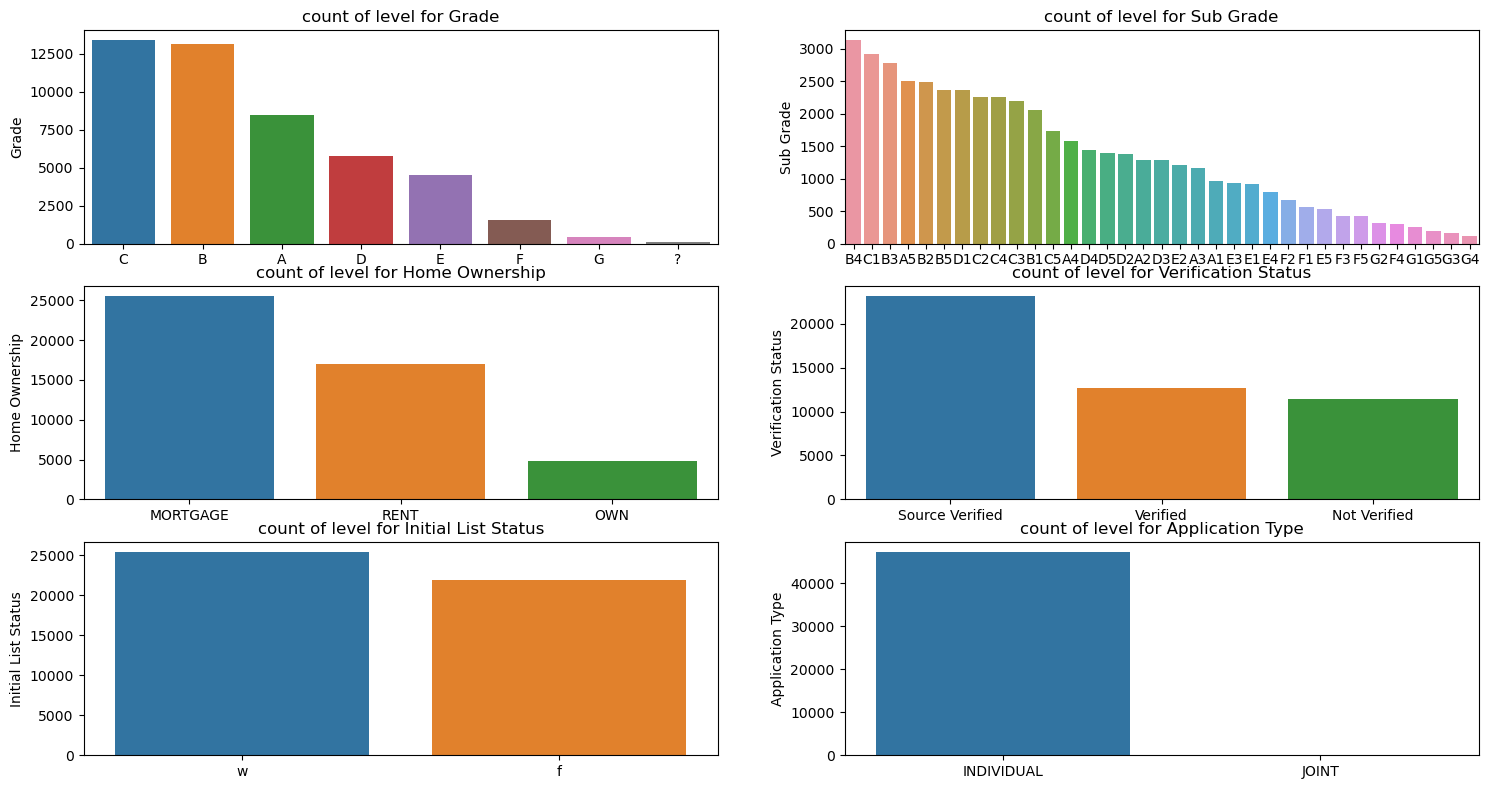

In [14]:
plt.figure(figsize = (18,36))
index = 1
for col in categorical_columns:
    if col not in ["Batch Enrolled","Loan Title","Payment Plan"]:
        y = train[col].value_counts()
        plt.subplot(11,2,index,title = "count of level for " + col)
        #plt.xticks(rotation = 90)
        sns.barplot(x = list(y.index),y = y, estimator="sum")
        index = index + 1
    

#### Count of loan Title

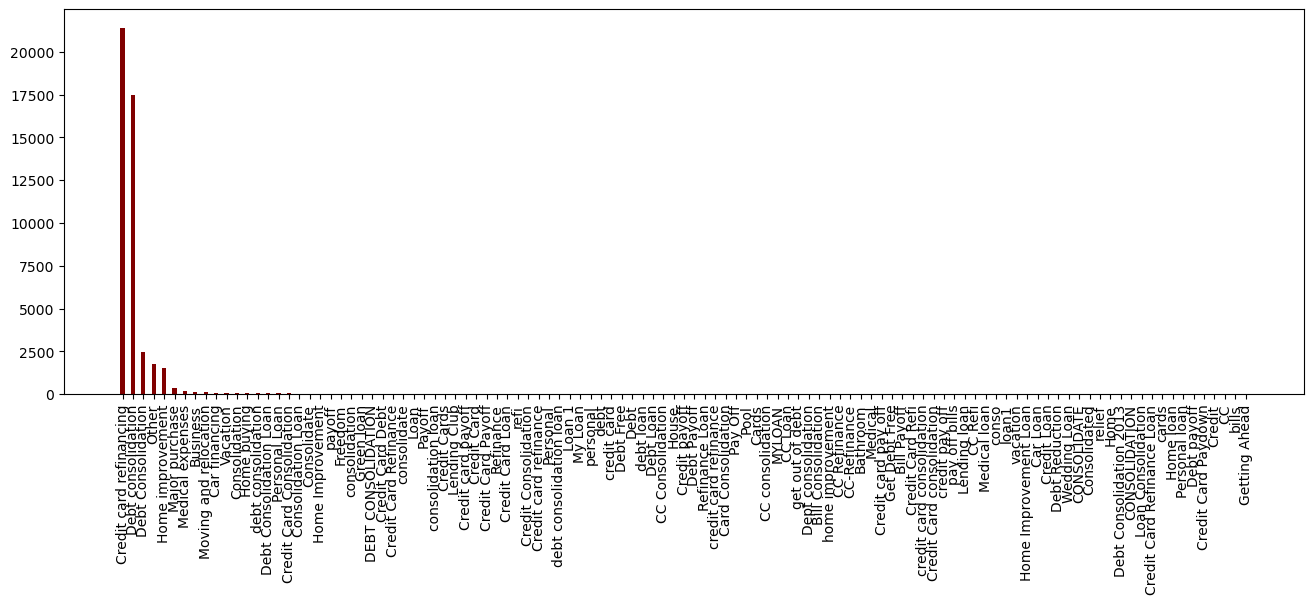

In [15]:
fig = plt.figure(figsize = (16, 5))
 
# creating the bar plot
plt.bar(train["Loan Title"].value_counts().index, train["Loan Title"].value_counts().values, color ='maroon', 
        width = 0.4)
plt.xticks(rotation = 90)
plt.show()

**The loan Title has too many categories with count less than fifty.Lets merge all those categories having counts less than 50 to new category called Other2.The category other is already present**

In [16]:
counts = train['Loan Title'].value_counts()
low_frequency_categories = list(counts[counts.lt(50)].index)
high_frequency_categories = set(counts.index) - set(low_frequency_categories)
train['Loan Title'] = ['Other2' if val in low_frequency_categories else val for val in train["Loan Title"]]
test['Loan Title'] = ['Other2' if val in low_frequency_categories else val for val in test["Loan Title"]]

Text(0.5, 1.0, 'percentage of laon default for different Batch Enrolled')

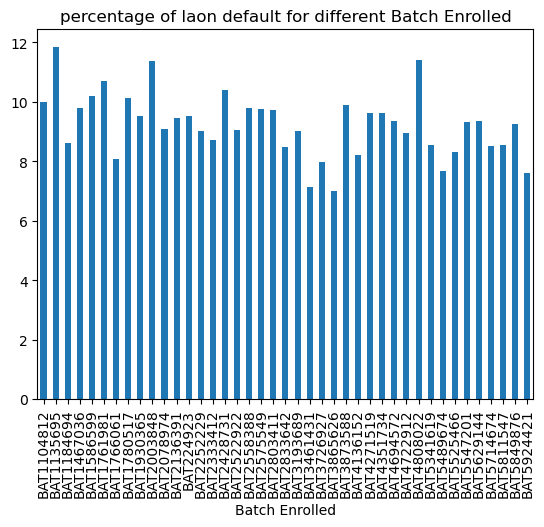

In [17]:
a = (train.groupby("Batch Enrolled")["Loan Status"].sum()/train.groupby("Batch Enrolled")["Loan Status"].count())*100
a.plot(kind = "bar")
plt.title("percentage of laon default for different Batch Enrolled")

**The percentage of loan default for different *Batch Enrolled* looks same.So Batch Enrolled valeiable may not be important
in making classification**

### Numerical Columns

In [18]:
train.drop(columns = 'ID').describe(exclude = 'object')

,Loan Amount,Funded Amount,Funded Amount Investor,Term,Interest Rate,Employment Duration,Debit to Income,Delinquency - two years,Inquires - six months,Open Account,...,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
count,47294.000000,47294.000000,47294.000000,47294.000000,47294.000000,47294.000000,47294.000000,47294.000000,47294.000000,47294.000000,...,47294.000000,47294.000000,47294.000000,47294.000000,47294.000000,47294.0,47294.000000,4.729400e+04,47294.000000,47294.000000
mean,16883.034012,15766.244788,14632.337679,58.193703,11.844178,80610.308978,23.297190,0.331374,0.147038,14.294033,...,1.145141,59.073029,1.115435,0.021715,71.173532,0.0,148.265975,1.593429e+05,23176.361949,0.092570
std,8296.276735,8146.324077,6792.462773,3.276851,3.706322,44859.049736,8.462028,0.804049,0.477553,6.256027,...,5.238521,354.832513,3.394797,0.145754,43.316625,0.0,757.716020,1.392703e+05,20996.064231,0.289832
min,1014.000000,1014.000000,1114.590204,36.000000,5.320006,14652.379680,0.675299,0.000000,0.000000,2.000000,...,0.000004,0.000036,0.000036,0.000000,0.000000,0.0,1.000000,6.170000e+02,1000.000000,0.000000
25%,10170.250000,9271.000000,9852.177923,58.000000,9.307720,51806.445042,16.733244,0.000000,0.000000,10.000000,...,0.021111,1.624399,0.477431,0.000000,35.000000,0.0,24.000000,5.017900e+04,8160.250000,0.000000
50%,16245.000000,13029.000000,12802.111910,59.000000,11.376095,69349.411170,22.659225,0.000000,0.000000,13.000000,...,0.043482,3.322949,0.780457,0.000000,68.000000,0.0,35.000000,1.175705e+05,16769.500000,0.000000
75%,22017.750000,21806.750000,17784.058075,59.000000,14.184996,94802.517405,30.066801,0.000000,0.000000,16.000000,...,0.071951,5.443535,1.069933,0.000000,105.000000,0.0,46.000000,2.278520e+05,32226.000000,0.000000
max,34999.000000,34999.000000,34999.746430,59.000000,27.070004,406561.536400,39.627576,8.000000,5.000000,37.000000,...,42.618882,4339.261318,53.465084,1.000000,161.000000,0.0,16421.000000,1.177412e+06,201169.000000,1.000000


#### Observation

1. Since we have only one unique value corresponding to field ***Accounts Delinquent* feild, it can be dropped.**
2. There is huge variability across numerical columns,so data require Scaling

<Axes: >

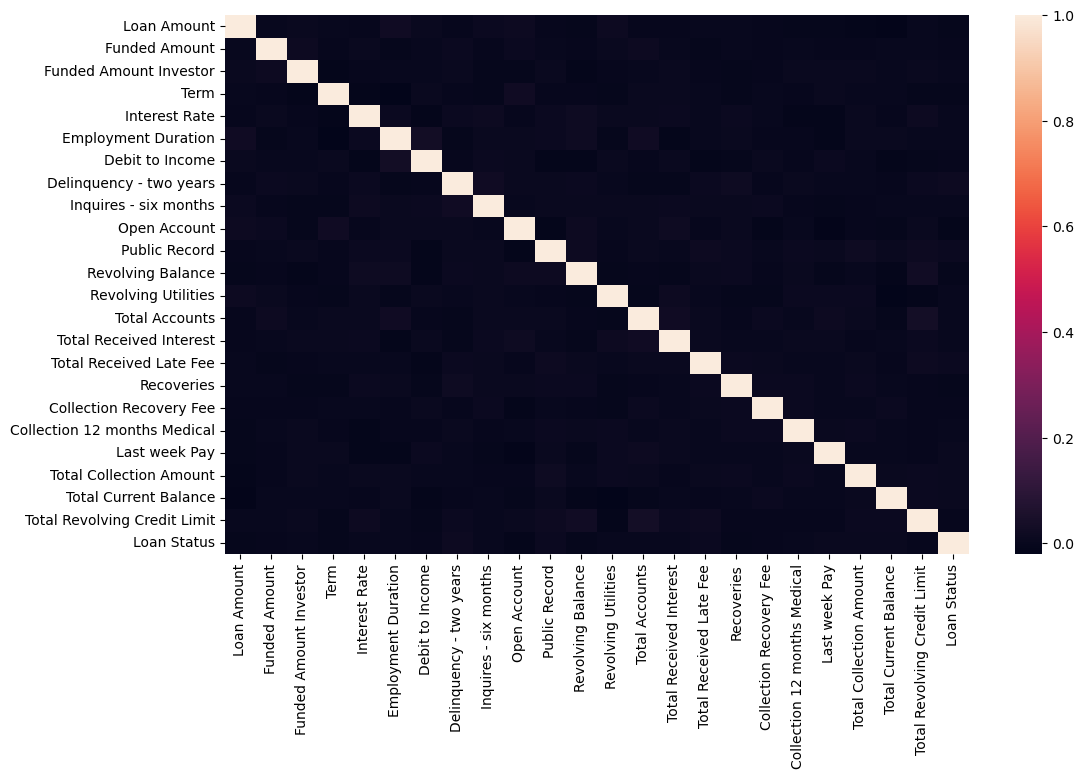

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (12, 7))
corr = train.select_dtypes(exclude = 'object').drop(columns = ["ID","Accounts Delinquent"]).corr()
sns.heatmap(corr)

**It seems almost no *very strong* correlations is existing between any numerical variables.**

In [20]:
X_train = train.drop(columns = ["ID","Loan Status","Payment Plan","Accounts Delinquent","Batch Enrolled"])
y_train = train["Loan Status"].astype(int)

X_test = test.drop(columns = ["ID","Loan Status","Payment Plan","Accounts Delinquent","Batch Enrolled"])
y_test = test["Loan Status"].astype(int)

In [21]:
categorical_col = [col for col in X_train.columns if X_train[col].dtypes == 'object']
numerical_col = list(set(X_train.columns) - set(categorical_col))

In [22]:
enc = OrdinalEncoder()
scaler = StandardScaler()

In [23]:
train_categorical_col = enc.fit_transform(X_train[categorical_col])

train_numerical_col = scaler.fit_transform(X_train[numerical_col])

X_train_transformed = pd.DataFrame(np.hstack((train_categorical_col,train_numerical_col)),
                columns = categorical_col + numerical_col)

In [24]:
test_categorical_col = enc.transform(X_test[categorical_col])

test_numerical_col = scaler.transform(X_test[numerical_col])

X_test_transformed = pd.DataFrame(np.hstack((test_categorical_col,test_numerical_col)),
                columns = categorical_col + numerical_col)

In [25]:
tree = DecisionTreeClassifier(random_state = 0)

In [26]:
tree.fit(X_train_transformed,y_train)

DecisionTreeClassifier(random_state=0)

In [27]:
print("Accuracy on training set: {:.3f}".format(tree.score(X_train_transformed, y_train)))

print("Accuracy on test set: {:.3f}".format(tree.score(X_test_transformed, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.816


**An appropriate metric is f1 score as we want do not want False postive as well as False Negative to be high**

In [28]:
y_pred = tree.predict(X_test_transformed)
print("f1 score on test set: {:.3f}".format(f1_score(y_test,y_pred)))

f1 score on test set: 0.105


In [29]:
X_train_transformed

,Grade,Sub Grade,Home Ownership,Verification Status,Loan Title,Initial List Status,Application Type,Total Accounts,Funded Amount Investor,Public Record,...,Open Account,Total Received Interest,Loan Amount,Recoveries,Interest Rate,Debit to Income,Total Received Late Fee,Total Current Balance,Employment Duration,Revolving Utilities
0,2.0,25.0,1.0,1.0,4.0,1.0,0.0,0.648196,0.805223,-0.233297,...,0.752237,-0.520744,-0.595699,-0.158068,-0.007324,0.148146,-0.217151,-0.900006,-0.699744,-0.519397
1,2.0,9.0,2.0,2.0,7.0,0.0,0.0,0.287173,-0.160250,-0.233297,...,0.112847,1.548572,0.175860,-0.152387,-1.710097,0.535568,-0.216146,2.313641,0.801978,0.164944
2,3.0,12.0,0.0,1.0,4.0,1.0,0.0,-0.916237,2.786059,-0.233297,...,-0.366696,-0.114022,-0.169118,-0.153686,-0.244878,-0.776744,-0.215199,-0.798986,-0.204087,-1.415069
3,2.0,21.0,0.0,2.0,7.0,1.0,0.0,0.287173,-0.582218,-0.233297,...,-0.206848,0.020279,1.139796,-0.158939,-0.375757,-0.261274,-0.208269,-0.972327,0.557267,1.887030
4,1.0,1.0,1.0,2.0,4.0,1.0,0.0,-1.758624,1.140153,-0.233297,...,-0.686391,0.225368,-0.391027,-0.155300,-0.580871,0.318822,-0.210344,0.280257,-0.046156,1.296946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47289,2.0,5.0,0.0,1.0,5.0,1.0,0.0,0.287173,-0.000049,-0.233297,...,-0.526543,2.220671,1.225981,-0.161851,-0.319121,-0.368629,-0.200678,-1.083034,-0.387706,0.139661
47290,2.0,5.0,0.0,2.0,4.0,0.0,0.0,-0.073850,-0.537990,-0.233297,...,-0.846238,-0.514511,0.437185,-0.158997,1.951804,0.225304,-0.212615,-0.486116,-0.973684,-0.731549
47291,4.0,15.0,2.0,0.0,7.0,1.0,0.0,0.768537,-0.474276,-0.233297,...,1.711323,-0.500576,0.563869,7.316171,-0.627708,0.805174,-0.207964,-0.857111,-0.022221,0.607269
47292,6.0,10.0,0.0,0.0,4.0,0.0,0.0,1.009219,-0.490024,-0.233297,...,-0.526543,-0.412224,1.894842,-0.159746,1.020394,1.547850,-0.218168,-0.826997,-0.392343,1.015918


**Clearly,we have a case of overfitting as we have a accuracy of 1.**<br>
**This was expected as decision tree is prove to overfitting. Lets now fit random forest as it is robust to overfitting**

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
rcf = RandomForestClassifier()
rcf.fit(X_train_transformed,y_train)
print("Accuracy on training set: {:.3f}".format(rcf.score(X_train_transformed, y_train)))
print("Accuracy on test set: {:.3f}".format(rcf.score(X_test_transformed, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.908


#### The overfitting is still not resolved

#### Lets decrease model complexity.This is can be done by the hyperparamter.
1. max_depth controls the depth of the tree.Shallow tree do not overfit the data.
2. Similiarly,min_samples_split and min_samples_leaf helps in avoiding overfiiting

In [32]:
rcf2 = RandomForestClassifier(n_estimators=200,max_depth = 6,min_samples_leaf=200,min_samples_split = 250)
rcf2.fit(X_train_transformed,y_train)
print("Accuracy on training set: {:.3f}".format(rcf2.score(X_train_transformed, y_train)))
print("Accuracy on test set: {:.3f}".format(rcf2.score(X_test_transformed, y_test)))

Accuracy on training set: 0.907
Accuracy on test set: 0.907


In [33]:
y_pred = rcf2.predict(X_test_transformed)
print("f1 score on test set: {:.3f}".format(f1_score(y_test,y_pred)))

f1 score on test set: 0.000


In [34]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     18392
           1       0.00      0.00      0.00      1877

    accuracy                           0.91     20269
   macro avg       0.45      0.50      0.48     20269
weighted avg       0.82      0.91      0.86     20269



C:\Users\91965\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\91965\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\91965\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**One reason of poor perfromance is due to imbalanced nature of the data.One way to deal with is to simulate the data using SMOTE**

In [35]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority',random_state = 0)

X_sm,y_sm = smote.fit_resample(X_train_transformed,y_train)

In [36]:
y_sm.value_counts()

0    42916
1    42916
Name: Loan Status, dtype: int64

In [1]:
rcf.fit(X_sm,y_sm)

NameError: name 'rcf' is not defined

In [2]:
print("Accuracy on training set: {:.3f}".format(rcf.score(X_sm,y_sm)))
print("Accuracy on test set: {:.3f}".format(rcf.score(X_test_transformed, y_test)))

NameError: name 'rcf' is not defined

In [39]:
y_pred = rcf.predict(X_test_transformed)
print("f1 score on test set: {:.3f}".format(f1_score(y_test,y_pred)))

f1 score on test set: 0.007


# Lets apply one final techinque of Neural Network

In [111]:
import tensorflow as tf

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense# Instantiate a sequential model
model = Sequential()

In [59]:
ohe = OneHotEncoder(sparse_output = False)

In [60]:
train_categorical_col = ohe.fit_transform(X_train[categorical_col])

train_numerical_col = scaler.fit_transform(X_train[numerical_col])

In [64]:
X_train_transformed = np.hstack((train_categorical_col,train_numerical_col))

In [65]:
test_categorical_col = ohe.transform(X_test[categorical_col])

test_numerical_col = scaler.transform(X_test[numerical_col])

X_test_transformed = np.hstack((test_categorical_col,test_numerical_col))

In [130]:
model = Sequential()
model.add(Dense(50, input_shape = (X_train_transformed.shape[1],),activation = 'relu'))
model.add(Dense(50,activation = 'relu'))
model.add(Dense(1,activation='softmax'))
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',
             metrics = ["tf.keras.metrics.F1Score"])

In [131]:
from tensorflow.keras.callbacks import EarlyStopping# Instantiate an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience = 5)  # Stops the training once val_loss stops improving.This allows us to
# chose high value for epochs

In [132]:
#model.fit(X_train_transformed, y_train, epochs = 10,validation_split = 0.2)
history = model.fit(X_train_transformed, y_train, 
                    epochs = 10,
                    validation_split = 0.2,
                    callbacks = [early_stopping])

Epoch 1/10


ValueError: in user code:

    File "C:\Users\91965\anaconda3\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\91965\anaconda3\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\91965\anaconda3\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\91965\anaconda3\lib\site-packages\keras\engine\training.py", line 894, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\91965\anaconda3\lib\site-packages\keras\engine\training.py", line 987, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\91965\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 480, in update_state
        self.build(y_pred, y_true)
    File "C:\Users\91965\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 393, in build
        self._metrics = tf.__internal__.nest.map_structure_up_to(
    File "C:\Users\91965\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 526, in _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "C:\Users\91965\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 526, in <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "C:\Users\91965\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 545, in _get_metric_object
        metric_obj = metrics_mod.get(metric)
    File "C:\Users\91965\anaconda3\lib\site-packages\keras\metrics\__init__.py", line 182, in get
        return deserialize(str(identifier))
    File "C:\Users\91965\anaconda3\lib\site-packages\keras\metrics\__init__.py", line 138, in deserialize
        return deserialize_keras_object(
    File "C:\Users\91965\anaconda3\lib\site-packages\keras\utils\generic_utils.py", line 709, in deserialize_keras_object
        raise ValueError(

    ValueError: Unknown metric function: tf.keras.metrics.F1Score. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.


In [96]:
history.history

{'loss': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'val_loss': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}

In [97]:
y_pred = model.predict(X_test_transformed)
print("f1 score on test set: {:.3f}".format(f1_score(y_test,y_pred)))

634/634 [==============================] - 2s 2ms/step
f1 score on test set: 0.170
